### Chapter 11

# CNN 모델 FashionMNIST

> ## 학습 목표
- CNN(Convolutional Neural Network) 모델을 효과적으로 설계하고 구현할 수 있다.
- FashionMNIST 데이터셋을 통해 CNN을 활용한 이미지 분류 작업에 대한 실무에 적용할 수 있다.
- PyTorch 프레임워크를 사용하여 모델의 성능을 평가하고, 최적화 기법을 적용하여 과적합 및 과소적합 문제를 해결하는 방법을 이해한다.
- 훈련 과정에서 정확도와 손실 값을 시각화하고 이를 통해 모델 학습의 경향을 분석하여, 지속적인 성능 개선을 위한 전략을 수립할 수 있다.

## **11.1 CNN 모델 구현**

**CNN은 주로 이미지 분류에 사용되는 신경망으로, 기본적으로 합성곱(Convolutional) 층, 풀링(Pooling) 층, 그리고 완전 연결(Fully Connected) 층으로 구성됩니다.**

> ### 기본적인 CNN 모델 구조

- Convolutional Layer (합성곱층): 이미지에서 특징을 추출하는 역할을 합니다.
- Activation Function (활성화 함수): 일반적으로 ReLU(Rectified Linear Unit) 함수를 사용하여 비선형성을 추가합니다.
- Pooling Layer (풀링층): 이미지의 크기를 줄여서 계산량을 감소시키고, 특징을 요약합니다.
- Fully Connected Layer (완전 연결층): 추출된 특징을 기반으로 분류를 수행합니다.

### 11.1.1. 라이브러리 임포트

In [1]:
import torch   # torch: PyTorch의 핵심 패키지로 텐서 연산 등을 제공.
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
# torchvision: PyTorch에서 컴퓨터 비전용 데이터셋, 모델 등을 제공.

### 11.1.2. CNN 모델 - 데이터 전처리 설정

In [2]:
# 데이터 전처리 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    # 이미지를 텐서로 변환
    # transforms.ToTensor(): PIL 이미지나 NumPy 배열을 PyTorch 텐서로 변환.
    transforms.Normalize((0.1307,), (0.3081,))  # 평균과 표준편차로 정규화
])

# 데이터셋 로드
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# datasets.MNIST: MNIST 데이터셋을 로드.
# train=True: 훈련 데이터 로드.
# train=False: 테스트 데이터 로드.
# download=True: 데이터셋이 없으면 다운로드.

# 데이터 로더 설정
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# DataLoader: 데이터셋을 배치(batch)단위로 분리, 반복 가능(iterable)하게 설정
# batch_size: 한 번에 처리할 데이터 샘플 수.
# shuffle: 데이터를 무작위로 섞을지 여부.

> ### CNN 모델 정의

- 모델을 클래스 형태로 정의하며, nn.Module을 상속받습니다.
- `__init__` 메서드에서 레이어를 초기화하고, forward 메서드에서 순전파(forward pass)를 정의합니다.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, 1) # 첫 번째 합성곱 레이어
        # 입력 채널 1, 출력 채널 32, 커널 크기 3x3, 스트라이드 1

        self.conv2 = nn.Conv2d(32, 64, 3, 1) # 두 번째 합성곱 레이어
        # 입력 채널 32, 출력 채널 64, 커널 크기 3x3, 스트라이드 1

        # 2x2 최대 풀링 레이어 정의
        self.pool = nn.MaxPool2d(2)

        # 첫 번째 전결합 층: 입력 9216, 출력 128
        # 9216 = 64채널 * 12 * 12 픽셀 (풀링 후 크기)
        self.fc1 = nn.Linear(9216, 128)

        # 두 번째 전결합 층: 입력 128, 출력 10 (클래스 수)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 첫 번째 합성곱 레이어와 ReLU 활성화 함수 적용
        x = F.relu(self.conv1(x))  # 출력 크기: [batch_size, 32, 26, 26]

        # 두 번째 합성곱 레이어와 ReLU 활성화 함수 적용
        x = F.relu(self.conv2(x))  # 출력 크기: [batch_size, 64, 24, 24]

        # 최대 풀링 적용
        x = self.pool(x)           # 출력 크기: [batch_size, 64, 12, 12]

        # 텐서를 1D 형태로 펼치기 (batch_size에 따라 자동 결정)
        x = x.view(-1, 9216)       # 출력 크기: [batch_size, 9216]

        # 첫 번째 전결합 층과 ReLU 활성화 함수 적용
        x = F.relu(self.fc1(x))    # 출력 크기: [batch_size, 128]

        # 두 번째 전결합 층 통과 (최종 클래스 예측)
        x = self.fc2(x)            # 출력 크기: [batch_size, 10]

        return x  # 모델의 최종 출력 반환

### 11.1.3. 모델 인스턴스 생성, 모델 요약 출력, 손실 함수 및 옵티마이저 설정
- 모델은 합성곱 레이어, 활성화 함수, 풀링 레이어, 완전 연결층 등을 포함하여 이미지 분류 작업을 수행할 수 있도록 구성됩니다. 
- 필요에 따라 레이어의 수나 파라미터를 조정하여 성능을 최적화할 수 있습니다.

In [4]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

# 크로스엔트로피오차 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 함수
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    # 모델을 학습 모드로 전환
    # model.train(): 드롭아웃, 배치 정규화 등 학습 시에만 사용되는 기능 활성화
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 데이터와 레이블을 장치에 할당
        optimizer.zero_grad() # 기울기 초기화
        output = model(data)  # 모델에 입력 데이터 전달하여 예측값 계산
        loss = criterion(output, target)  # 손실 계산
        loss.backward()  # 역전파 단계, 역전파를 통해 기울기 계산
        optimizer.step() # 가중치 업데이트, 역전파를 통해 기울기 계산

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# 평가 함수
def test(model, device, test_loader):
    model.eval()
    # 모델을 평가 모드로 전환
    # model.eval(): 드롭아웃, 배치 정규화 등 평가 시에만 사용되는 기능 비활성화.
    test_loss = 0
    correct = 0
    with torch.no_grad():
    # 기울기 계산 비활성화
    # torch.no_grad(): 기울기 계산을 하지 않아 메모리 사용량 감소 및 속도 향상.
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # 데이터와 레이블을 장치에 할당
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            # 배치 손실 합산
            pred = output.argmax(dim=1, keepdim=True)
            # 가장 높은 값을 가진 클래스 선택
            # output.argmax(dim=1): 각 샘플에 대한 예측 클래스 반환.
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)  # 평균 손실 계산
    accuracy = 100. * correct / len(test_loader.dataset)  # 정확도 계산

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
        f' ({accuracy:.2f}%)\n')

    # 학습 및 평가 실행
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# GPU 사용 여부 결정, GPU를 사용할 수 있으면 사용하고, 아니면 CPU 사용
model.to(device)
# 모델을 장치에 할당, model.to(device): 모델의 파라미터를 장치에 할당.

num_epochs = 5
# 학습 에포크 수, num_epochs: 전체 데이터셋을 몇 번 반복 학습할지 결정.

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310386
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.128681
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.150774
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.071882
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.107641
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.172421
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.030260
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.013088
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.118104
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.034567

Test set: Average loss: 0.0477, Accuracy: 9851/10000 (98.51%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.112661
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.080145
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.005845
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.018548
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.004675
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.034924
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.065419
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.068634
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.02422

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 데이터와 타겟을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        output = model(data)  # 데이터 처리
        loss = criterion(output, target)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        total_loss += loss.item()  # 손실 축적

        if batch_idx % 100 == 0:  # 간헐적으로 손실 출력
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    return total_loss / len(train_loader)  # 평균 손실 반환

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# GPU 사용 가능시 GPU로 설정
model = model.to(device)  # 모델을 GPU로 이동


In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        output = model(data)  # 데이터 처리
        loss = criterion(output, target)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        # 손실 출력
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # GPU로 이동
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
        f' ({accuracy:.2f}%)\n')

    return test_loss, accuracy  # 평균 손실과 정확도 반환

In [9]:
# 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim

# 모델 클래스 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 784)  # 입력 평탄화
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.logsoftmax(x)

# 환경 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)  # 모델을 장치로 이동

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 여기에 train_loader, test_loader 설정이 필요합니다.

# 훈련 반복
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.313923
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.304569
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.332360
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.217830
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.159441
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.154495
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.205194
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.181210
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.074164
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.070777

Test set: Average loss: 0.1120, Accuracy: 9649/10000 (96.49%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.082685
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.101554
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.174628
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.022277
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.155160
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.040325
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.043689
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.146917
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.01472

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.349125
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.496329
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.272561
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.274243
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.082876
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.152165
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.353080
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.149461
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.071099
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.145872

Test set: Average loss: 0.1206, Accuracy: 9632/10000 (96.32%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.020072
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.074278
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.079900
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.037338
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.107854
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.020621
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.080613
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.072865
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.01424

TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'

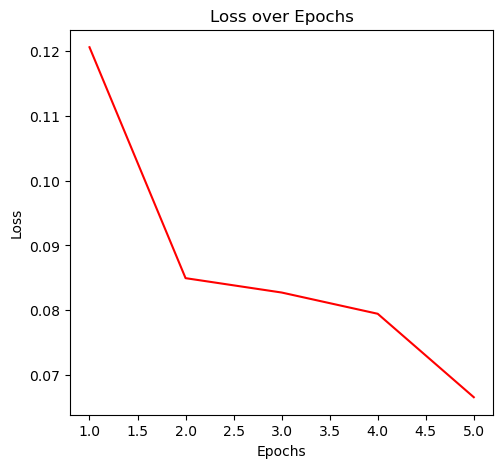

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 784)  # 입력 평탄화
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.logsoftmax(x)

# 장치 설정 및 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실과 정확도를 저장할 리스트 생성
train_losses = []
test_losses = []
accuracies = []

# 에포크 수 설정
num_epochs = 5

# 모델 훈련 및 테스트
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)

    # 손실과 정확도 기록
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

# 결과 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, max(max(train_losses), max(test_losses)) + 1)  # Y축 범위 설정
plt.legend()
plt.grid()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Y축 범위 설정
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

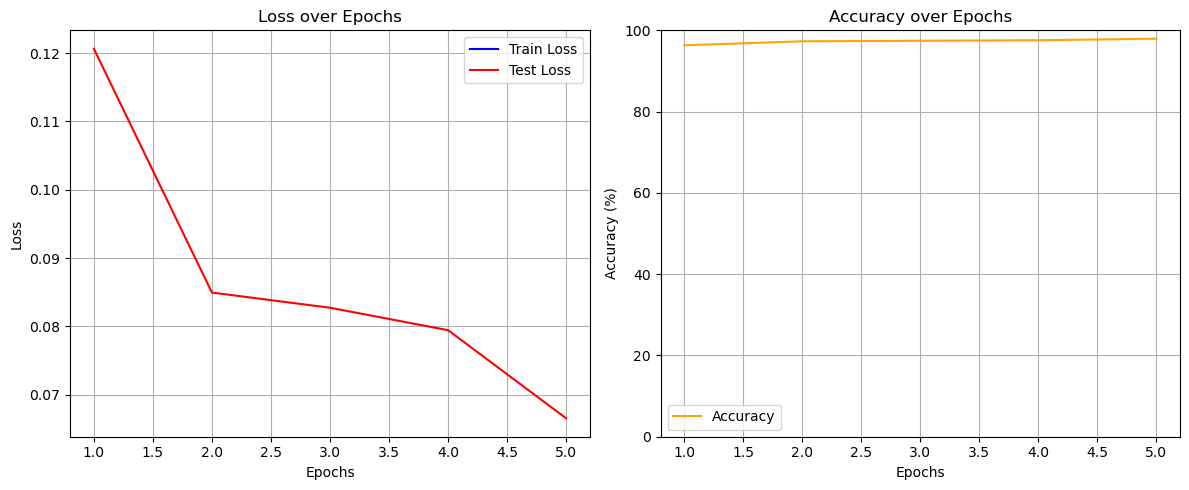

In [18]:
# 결과 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0, max(max(train_losses), max(test_losses)) + 1)  # Y축 범위 설정
plt.legend()
plt.grid()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Y축 범위 설정
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

5. 그래프 표시 방식 점검

시각화가 제대로 표시되지 않거나 단순히 보이지 않을 수 있습니다. Jupyter Notebook 사용 시 경우에 따라, %matplotlib inline을 선언하여 그래프가 바로 나타나게 해주기도 합니다:

In [12]:
%matplotlib inline

결론

위의 확인 사항을 하나하나 점검해보시고, 훈련 손실 값이 리스트에 잘 저장되고 그래프에 올바르게 표시되도록 수정해 보세요. 여전히 문제가 지속된다면 추가로 정보를 제공해 주시면 더 도와드릴 수 있습니다.

In [19]:
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)

    # 손실과 정확도 기록
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

# 손실 값 기록 확인
print(f"Train Losses: {train_losses}")
print(f"Test Losses: {test_losses}")


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.015167
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.001856
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.035778
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.010053
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.032216
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.035873
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.026798
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.050207
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.028642
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.004699

Test set: Average loss: 0.0799, Accuracy: 9779/10000 (97.79%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.006610
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.026726
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.005629
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.022757
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.053695
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.005119
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.018825
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.038597
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.05727

In [26]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # 데이터 및 타겟을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        output = model(data)  # 데이터 처리
        loss = criterion(output, target)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        total_loss += loss.item()  # 손실 축적

    return total_loss / len(train_loader)  # 평균 손실 반환


In [29]:
# 손실 값이 비어 있지 않다면 시각화
filtered_train_losses = [loss for loss in train_losses if loss is not None]
if filtered_train_losses:
    plt.ylim(min(filtered_train_losses) - 1, max(filtered_train_losses) + 1)  # Y축 범위 설정
else:
    print("Train losses is empty!")


Train losses is empty!


In [31]:
# 모델 훈련 및 테스트
num_epochs = 5  # 에포크 수 설정

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)

    # 리스트에 저장
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)



Test set: Average loss: 0.0937, Accuracy: 9790/10000 (97.90%)


Test set: Average loss: 0.1103, Accuracy: 9770/10000 (97.70%)


Test set: Average loss: 0.1053, Accuracy: 9794/10000 (97.94%)


Test set: Average loss: 0.1281, Accuracy: 9779/10000 (97.79%)


Test set: Average loss: 0.1111, Accuracy: 9778/10000 (97.78%)



In [32]:
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)
print("Accuracy:", accuracy)

Train Loss: 0.011850964877538976
Test Loss: 0.11108720311895012
Accuracy: 97.78


In [39]:
# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Y축 범위 설정
filtered_train_losses = [loss for loss in train_losses if loss is not None]
if filtered_train_losses and test_losses:
    plt.ylim(min(min(filtered_train_losses), min(test_losses)) - 1, max(max(filtered_train_losses), max(test_losses)) + 1)  # Y축 범위 설정
else:
    plt.ylim(0, 1)  # 기본값 설정

plt.legend()
plt.grid()

In [37]:
%matplotlib inline

In [41]:
import matplotlib.pyplot as plt

# 결과 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Y축 범위 설정
if train_losses and test_losses:
    plt.ylim(min(min(train_losses), min(test_losses)) - 1, max(max(train_losses), max(test_losses)) + 1)  # Y축 범위 설정
else:
    plt.ylim(0, 1)  # 기본값 설정

plt.legend()
plt.grid()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Y축 범위 설정

plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # 그래프 출력


TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [42]:
print(f"Train Losses: {train_losses}")
print(f"Test Losses: {test_losses}")
print(f"Accuracies: {accuracies}")

Train Losses: [None, None, None, None, None, None, None, None, None, None, 0.0140777267175869, 0.012066390580241441, 0.013485817083198811, 0.009937535553006471, 0.010311994839878746, 0.009616948669463067, 0.011850964877538976]
Test Losses: [0.12062396481633186, 0.08495312202721834, 0.0827333701774478, 0.07945102136582136, 0.06656148694455624, 0.07991487290710211, 0.07398038310930133, 0.08116816189140082, 0.08534582611173391, 0.08955381531268358, 0.10884398128837347, 0.10327701792120933, 0.09368326338008046, 0.11031660437583923, 0.10525933038443328, 0.12806827072054147, 0.11108720311895012]
Accuracies: [96.32, 97.31, 97.44, 97.56, 97.94, 97.79, 98.0, 97.87, 97.88, 97.81, 97.49, 97.75, 97.9, 97.7, 97.94, 97.79, 97.78]


----

## **11. 2 CNN 모델 구현 실습**

> ## FashionMNIST을 이용한 CNN 모델 구현

**FashionMNIST**는 머신러닝 및 컴퓨터 비전 분야에서 널리 사용되는 데이터셋입니다. 
- Zalando의 기사 이미지 데이터 세트로, 60,000개의 예제로 구성된 훈련 세트와 10,000개의 예제로 구성된 테스트 세트로 구성되어 있습니다. 각 예제는 28x28 회색조 이미지이며, 10개 클래스의 레이블과 연관되어 있습니다. 
- https://www.kaggle.com/datasets/zalando-research/fashionmnist
- 원본 데이터 세트는 https://github.com/zalandoresearch/fashion-mnist


### 11.2.1 기본 정보

-   **목적**: FashionMNIST는 패션 아이템 분류 문제를 해결하기 위한 데이터셋으로, 복잡한 이미지 인식 작업에서 신경망 학습의 유용성을 demonstrate하기 위해 만들어졌습니다.
-   **형태**: FashionMNIST는 10개의 서로 다른 카테고리로 나누어진 28x28 픽셀의 흑백 이미지로 이루어져 있습니다.

### 11.2.2 데이터셋 구성

-   **훈련 데이터**: 60,000개의 이미지
-   **테스트 데이터**: 10,000개의 이미지
-   **총 이미지 수**: 70,000개

### 11.2.3 클래스

FashionMNIST는 다음과 같은 10개의 클래스 레이블을 포함하고 있습니다:

0.  티셔츠/top (T-shirt/top)
1.  바지 (Trouser)
2.  풀오버 (Pullover)
3.  드레스 (Dress)
4.  코트 (Coat)
5.  샌들 (Sandal)
6.  셔츠 (Shirt)
7.  운동화 (Sneaker)
8.  가방 (Bag)
9.  앵클 부츠 (Ankle boot)

### 11.2.4 사용 이유

-   **대체 데이터셋**: FashionMNIST는 전통적인 MNIST 데이터셋(손글씨 숫자)을 대체하기 위해 설계되었습니다. 패션 아이템의 분류로 더욱 복잡한 시각적 문제를 해결할 수 있도록 돕습니다.
-   **단순성**: 구조가 간단하여 초보자들이 CNN 및 다른 알고리즘을 실험하는 데 적합합니다.
-   **다양성**: 패션 데이터의 다양한 카테고리로 인해 더 복잡한 분류 작업을 테스트할 수 있습니다.

### 11.2.5 접근 방법

FashionMNIST 데이터셋은 PyTorch, TensorFlow 등 다양한 머신러닝 프레임워크에서 쉽게 불러와 사용할 수 있는 형태로 제공됩니다.

결론적으로, FashionMNIST는 머신러닝 모델을 학습하고 평가하는 데 유용한 데이터셋으로, 이미지 분류 문제를 해결하는 데 널리 사용됩니다.

1) 라이브러리 불러오기

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

2) 데이터셋 준비

- FashionMNIST 데이터셋을 다운로드하고, 데이터를 전처리할 트랜스폼을 정의합니다.

In [44]:
# 데이터 전처리 (Tensor로 변환하고, 정규화)
transform = transforms.Compose([
    transforms.ToTensor(),                # 이미지를 Tensor로 변환
    transforms.Normalize((0.5,), (0.5,))  # 정규화 (0~1 사이로 스케일링)
])

# 학습 데이터셋과 테스트 데이터셋 불러오기
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:06<00:00, 4268539.48it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 93847.78it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1444426.10it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3180011.34it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



3. CNN 모델 정의

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layer 1 (합성곱 층)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Fully connected layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes (FashionMNIST의 클래스 수)

    def forward(self, x):
        # Convolution + MaxPooling + ReLU Activation
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten(다차원 배열을 1차원 벡터로 변환)
        x = x.view(-1, 64 * 7 * 7)

        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # 마지막 출력층 (Logits)

        return x

4. 모델 학습 설정
- 모델을 학습시키기 위한 손실 함수와 최적화 알고리즘을 정의합니다.

In [46]:
# 모델 초기화
model = CNN()

# 손실 함수 (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# 최적화 알고리즘 (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

5. 모델 학습

In [47]:
"""
#device 설정
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CNN().to(device)
"""
# CPU 사용 설정
device = torch.device("cpu")

# 모델을 device로 이동
model = model.to(device)


In [48]:
# 학습 함수
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            # GPU 사용 가능시 모델을 GPU로 이동
            #inputs, labels = inputs.cuda(), labels.cuda()
            # cpu일 때 데이터를 device로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            # 기울기 초기화
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 통계 업데이트
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # 에폭당 출력
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total}%')

# CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 모델 학습
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.42921079158274605, Accuracy: 84.63166666666666%
Epoch 2/5, Loss: 0.2773059255945911, Accuracy: 89.845%
Epoch 3/5, Loss: 0.230994374870555, Accuracy: 91.64833333333333%
Epoch 4/5, Loss: 0.19768872991331352, Accuracy: 92.72333333333333%
Epoch 5/5, Loss: 0.17053983206830936, Accuracy: 93.76666666666667%


6. 모델 평가

In [49]:
# 평가 함수
def evaluate_model(model, test_loader):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    with torch.no_grad():  # 기울기 계산을 하지 않음
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on test data: {100 * correct / total}%')

# 모델 평가
evaluate_model(model, test_loader)

Accuracy on test data: 91.58%


7. 모델 예측 시각화
- 테스트 데이터 중 일부 이미지를 모델로 예측하고 결과를 시각화합니다.

In [54]:
# 모델 예측 시각화
def visualize_predictions(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    for inputs, labels in test_loader:
        # 데이터를 device로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        # 예측 수행
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # 이미지 출력
        fig, axes = plt.subplots(1, 5, figsize=(12, 6))
        for i in range(5):
            ax = axes[i]
            ax.imshow(inputs[i][0].cpu(), cmap='gray')
            # .cpu()로 CPU로 이동시킨 후 시각화
            ax.set_title(f'Pred: {predicted[i].item()}, True: {labels[i].item()}')
            ax.axis('off')
        plt.show()
        break  # 첫 번째 배치만 시각화


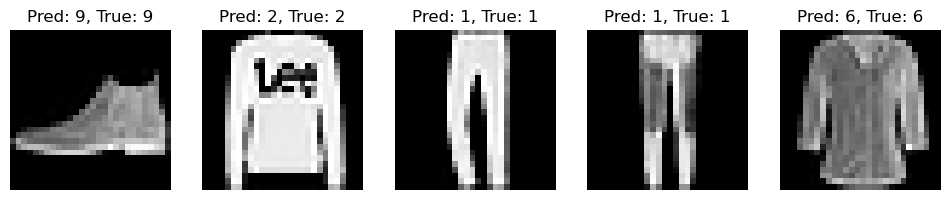

In [55]:
visualize_predictions(model, test_loader, device)

# **`Classifying Clothing Images`**

In [56]:
# Import the necessary libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [57]:
!pip install humanize

In [58]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=5a21dd8f01039dac7191f449f2a8b93d4ae77793b6561769d5c48dfcd98ab4df
  Stored in directory: /Users/joshuapark/Library/Caches/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil


In [59]:
!pip install matplotlib

In [60]:
# GPU check
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

IndexError: list index out of range

In [61]:
# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

100%|██████████| 26421880/26421880 [00:08<00:00, 3232109.40it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 113301.36it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2035447.87it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2185010.83it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



In [62]:
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 데이터 정규화
])

In [63]:
# 데이터셋 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 평균과 표준편차로 정규화
])

# FashionMNIST 데이터셋 다운로드 및 로드
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# 시험삼아 데이터 로드
dataiter = iter(trainloader)
images, labels = next(dataiter)  # 배치 가져오기

# 데이터 확인
print(images.shape)  # (batch_size, 1, 28, 28) 형인지 확인
print(labels.shape)  # (batch_size, ) 형인지 확인


torch.Size([64, 1, 28, 28])
torch.Size([64])


In [64]:
# 데이터셋 변환 및 데이터 로더 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 평균과 표준편차로 정규화
])

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

# Define the network architecture
model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

# Define the loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training Loop
epochs = 30
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    model.train()  # Set the model to training mode
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)  # Flatten the input

        optimizer.zero_grad()  # Zero the gradients
        output = model(images)  # Forward pass
        loss = criterion(output, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimizer step

        running_loss += loss.item()  # Total loss

    # Validation pass
    model.eval()  # Set the model to evaluation mode
    test_loss, accuracy = 0, 0
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in testloader:
            images = images.view(images.shape[0], -1)  # Flatten the input
            log_ps = model(images)  # Get model output
            test_loss += criterion(log_ps, labels)  # Calculate loss

            ps = torch.exp(log_ps)  # Convert log probabilities to probabilities
            top_p, top_class = ps.topk(1, dim=1)  # Get top class
            equals = top_class == labels.view(*top_class.shape)  # Compare with true labels
            accuracy += torch.mean(equals.type(torch.FloatTensor))  # Calculate accuracy

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print(f"Epoch: {e + 1}/{epochs}.. "
        f"Training loss: {running_loss/len(trainloader):.3f}.. "
        f"Test loss: {test_loss/len(testloader):.3f}.. "
        f"Test Accuracy: {accuracy/len(testloader):.3f}")


Epoch: 1/30.. Training loss: 0.597.. Test loss: 0.446.. Test Accuracy: 0.834
Epoch: 2/30.. Training loss: 0.453.. Test loss: 0.412.. Test Accuracy: 0.845
Epoch: 3/30.. Training loss: 0.419.. Test loss: 0.403.. Test Accuracy: 0.849
Epoch: 4/30.. Training loss: 0.402.. Test loss: 0.385.. Test Accuracy: 0.861
Epoch: 5/30.. Training loss: 0.387.. Test loss: 0.398.. Test Accuracy: 0.852
Epoch: 6/30.. Training loss: 0.377.. Test loss: 0.402.. Test Accuracy: 0.859
Epoch: 7/30.. Training loss: 0.367.. Test loss: 0.384.. Test Accuracy: 0.864
Epoch: 8/30.. Training loss: 0.358.. Test loss: 0.373.. Test Accuracy: 0.868
Epoch: 9/30.. Training loss: 0.348.. Test loss: 0.357.. Test Accuracy: 0.872
Epoch: 10/30.. Training loss: 0.348.. Test loss: 0.356.. Test Accuracy: 0.874
Epoch: 11/30.. Training loss: 0.340.. Test loss: 0.364.. Test Accuracy: 0.870
Epoch: 12/30.. Training loss: 0.331.. Test loss: 0.368.. Test Accuracy: 0.867
Epoch: 13/30.. Training loss: 0.332.. Test loss: 0.364.. Test Accuracy: 0

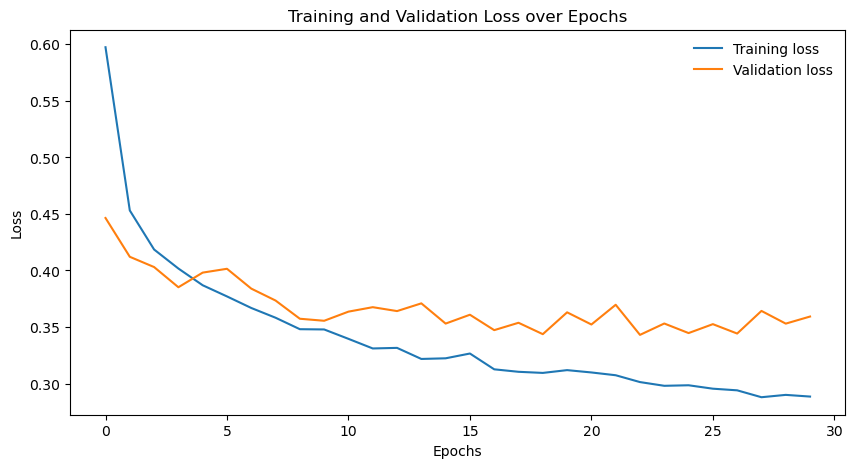

In [65]:
# 손실 그래프 시각화
plt.figure(figsize=(10, 5))  # 그림의 크기 지정
plt.plot(train_losses, label="Training loss")  # 훈련 손실
plt.plot(test_losses, label="Validation loss")  # 검증 손실
plt.legend(frameon=False)  # 범례 추가 (테두리 없음)
plt.xlabel("Epochs")  # x축 레이블
plt.ylabel("Loss")  # y축 레이블
plt.title("Training and Validation Loss over Epochs")  # 제목
plt.show()  # 그래프 표시


**Overfitting**

The training loss decreases with each epoch but the validation loss increases after some epochs. It is a clear case of overfitting. Solutions to tackle overfitting:

1. Early stopping - From the graph it's clear that on stopping at 10 epochs I can get a better validation as well as training loss.

2. Dropout - Randomly drop input units.

과적합(Overfitting)

훈련 손실은 에포크가 지남에 따라 감소하지만, 검증 손실은 몇 개의 에포크 이후 증가합니다. 이는 명백한 과적합 사례입니다. 과적합을 해결하기 위한 방법은 다음과 같습니다:


조기 중단(Early stopping) - 그래프를 보면 10 에포크에서 학습을 중단하면 더 나은 검증 및 훈련 손실을 얻을 수 있습니다.



드롭아웃(Dropout) - 입력 단위를 무작위로 제거합니다.

In [66]:
# Define view_classify function
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

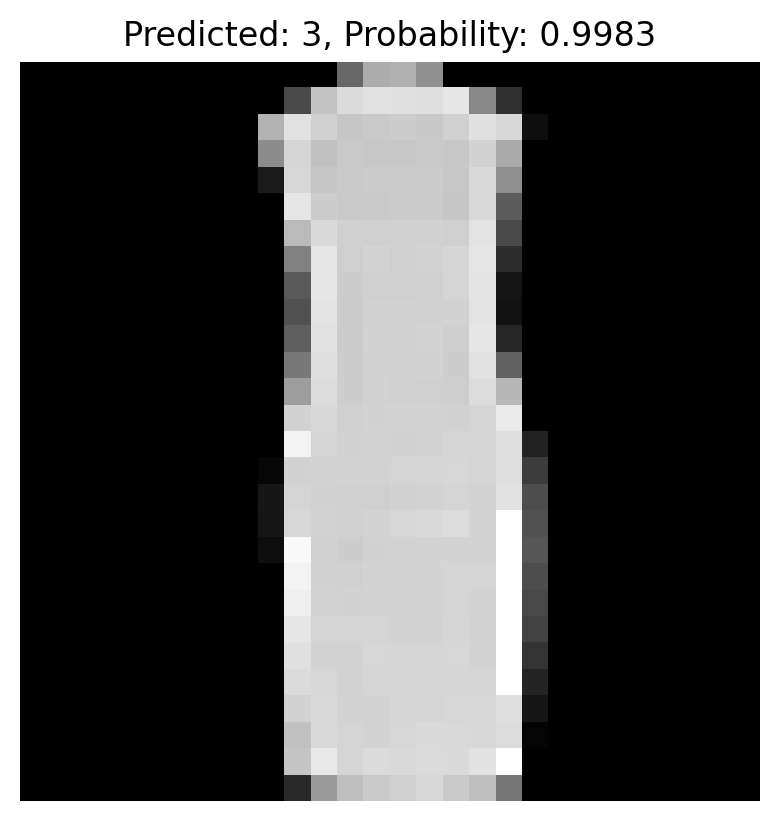

In [68]:
import matplotlib.pyplot as plt
import torch

# Inline plotting commands for Jupyter Notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Testing the network
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (log softmax) for img
ps = torch.exp(model(img))

# Define the view_classify function
def view_classify(img, ps, version='Fashion'):
    """Function for displaying an image and its predicted probability distribution"""
    img = img.view(28, 28).detach().numpy()  # 2D 이미지로 변환
    plt.imshow(img, cmap='gray')  # 이미지 시각화
    plt.title(f'Predicted: {ps.argmax().item()}, Probability: {ps.max().item():.4f}')  # 예측 및 확률 표시
    plt.axis('off')  # 축 비활성화
    plt.show()  # 그래프 표시

# Plot the image and probabilities using the view_classify function
view_classify(img, ps, version='Fashion')


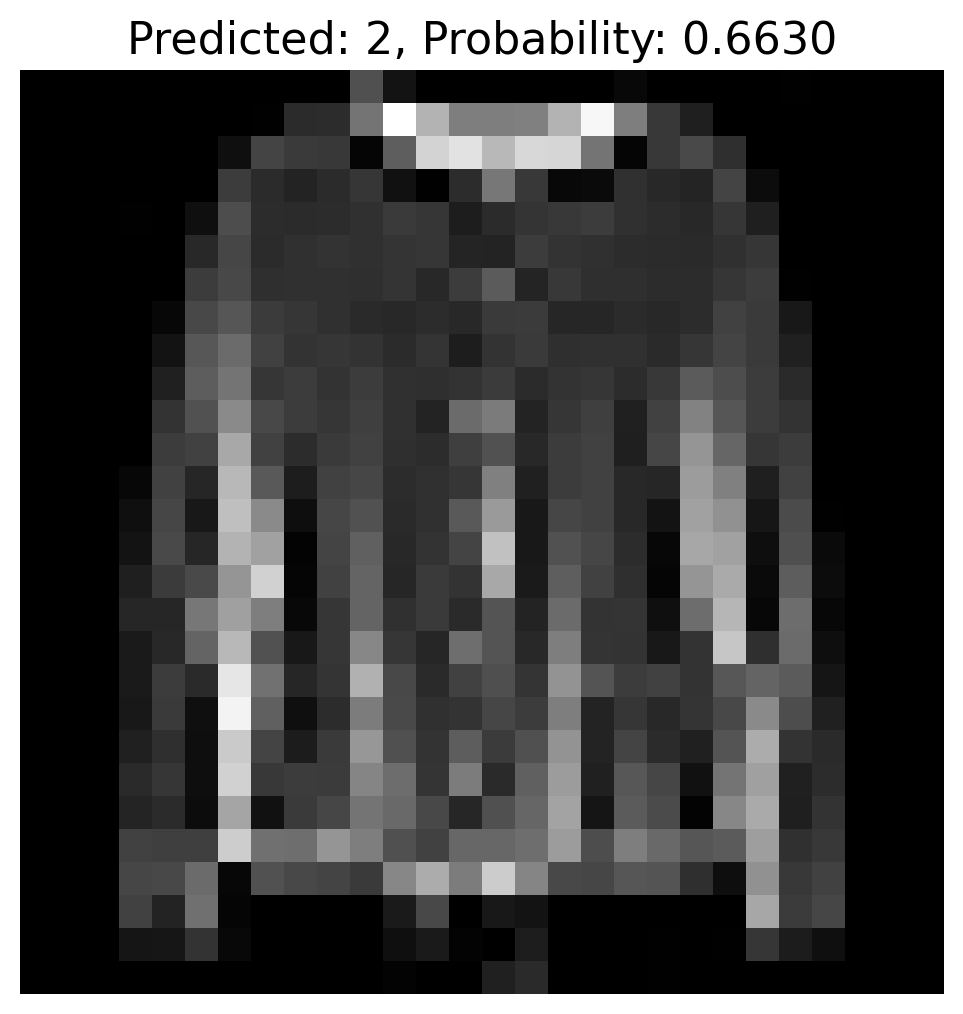

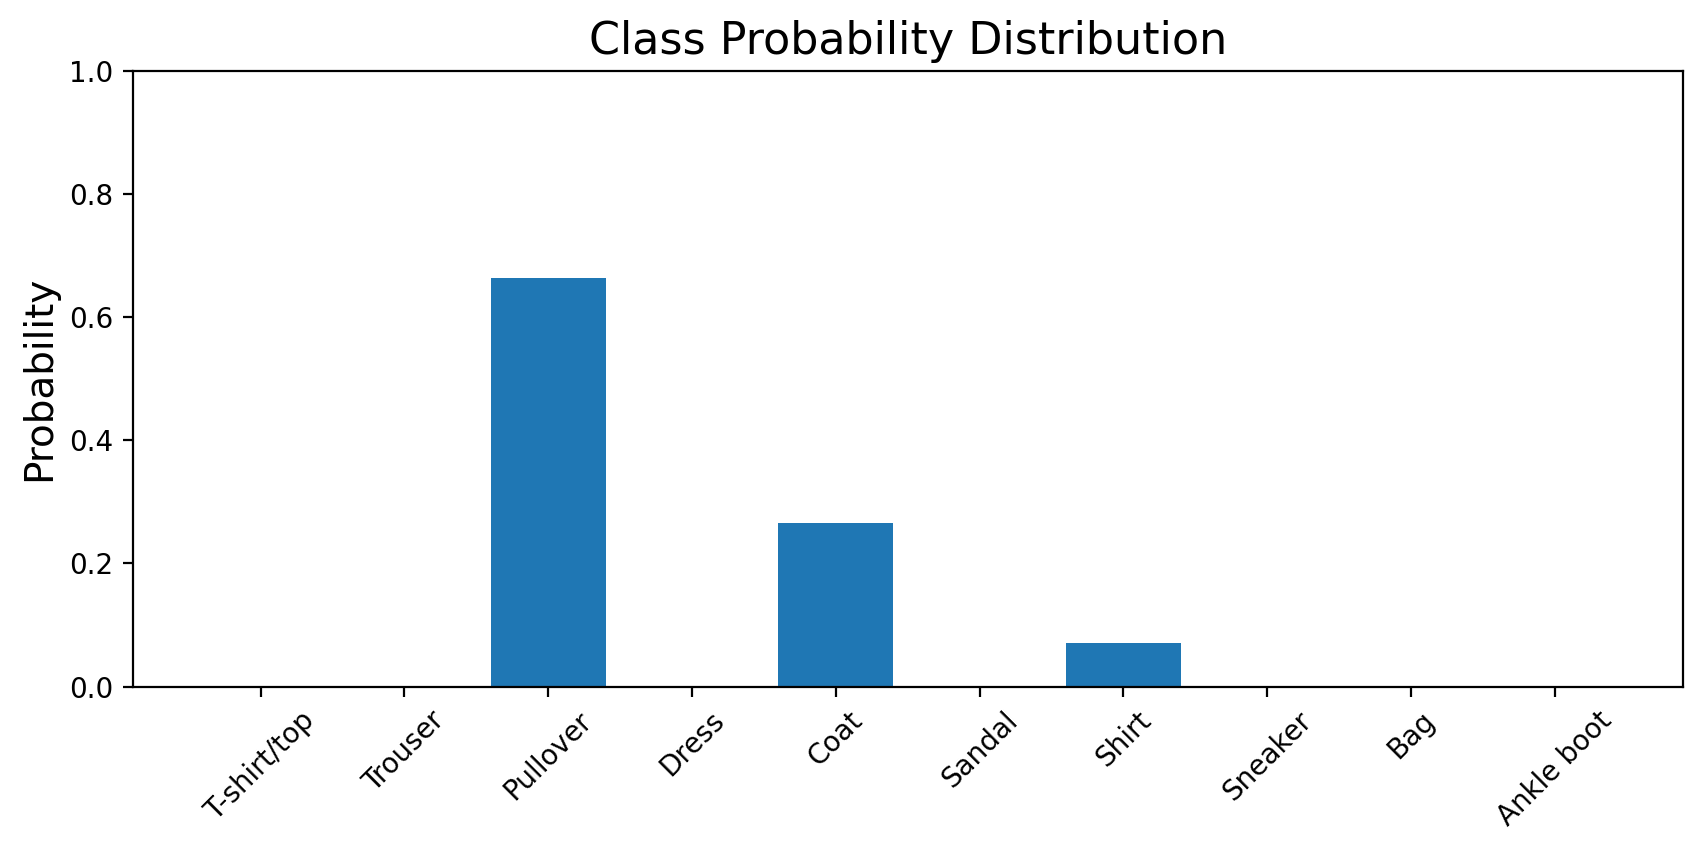

In [69]:
import matplotlib.pyplot as plt
import torch

# Inline plotting commands for Jupyter Notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Testing the network
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (log softmax) for img
ps = torch.exp(model(img))

# Define the view_classify function
def view_classify(img, ps, version='Fashion'):
    """Function for displaying an image and its predicted probability distribution"""

    # 1. Display the image
    plt.figure(figsize=(6, 6))  # 이미지 크기 지정
    img = img.view(28, 28).detach().numpy()  # 2D 이미지로 변환
    plt.imshow(img, cmap='gray')  # 이미지 시각화
    plt.title(f'Predicted: {ps.argmax().item()}, Probability: {ps.max().item():.4f}', fontsize=16)  # 타이틀 크기 조정
    plt.axis('off')  # 축 비활성화

    # 2. Display the probability distribution as a bar chart
    plt.figure(figsize=(10, 4))  # 바 차트 크기 지정
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # 클래스 이름
    plt.bar(classes, ps.view(-1).detach().numpy())  # 확률 바 차트
    plt.title('Class Probability Distribution', fontsize=16)  # 타이틀 크기 조정
    plt.ylabel('Probability', fontsize=14)  # y축 레이블
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.ylim(0, 1)  # y축 범위 설정
    plt.show()  # 그래프 표시

# Plot the image and probabilities using the view_classify function
view_classify(img, ps, version='Fashion')

/var/folders/tf/zyfvd5155bzf5mslsy874x0c0000gn/T/ipykernel_17256/2912261133.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(classes, rotation=45)  # x축 레이블 회전


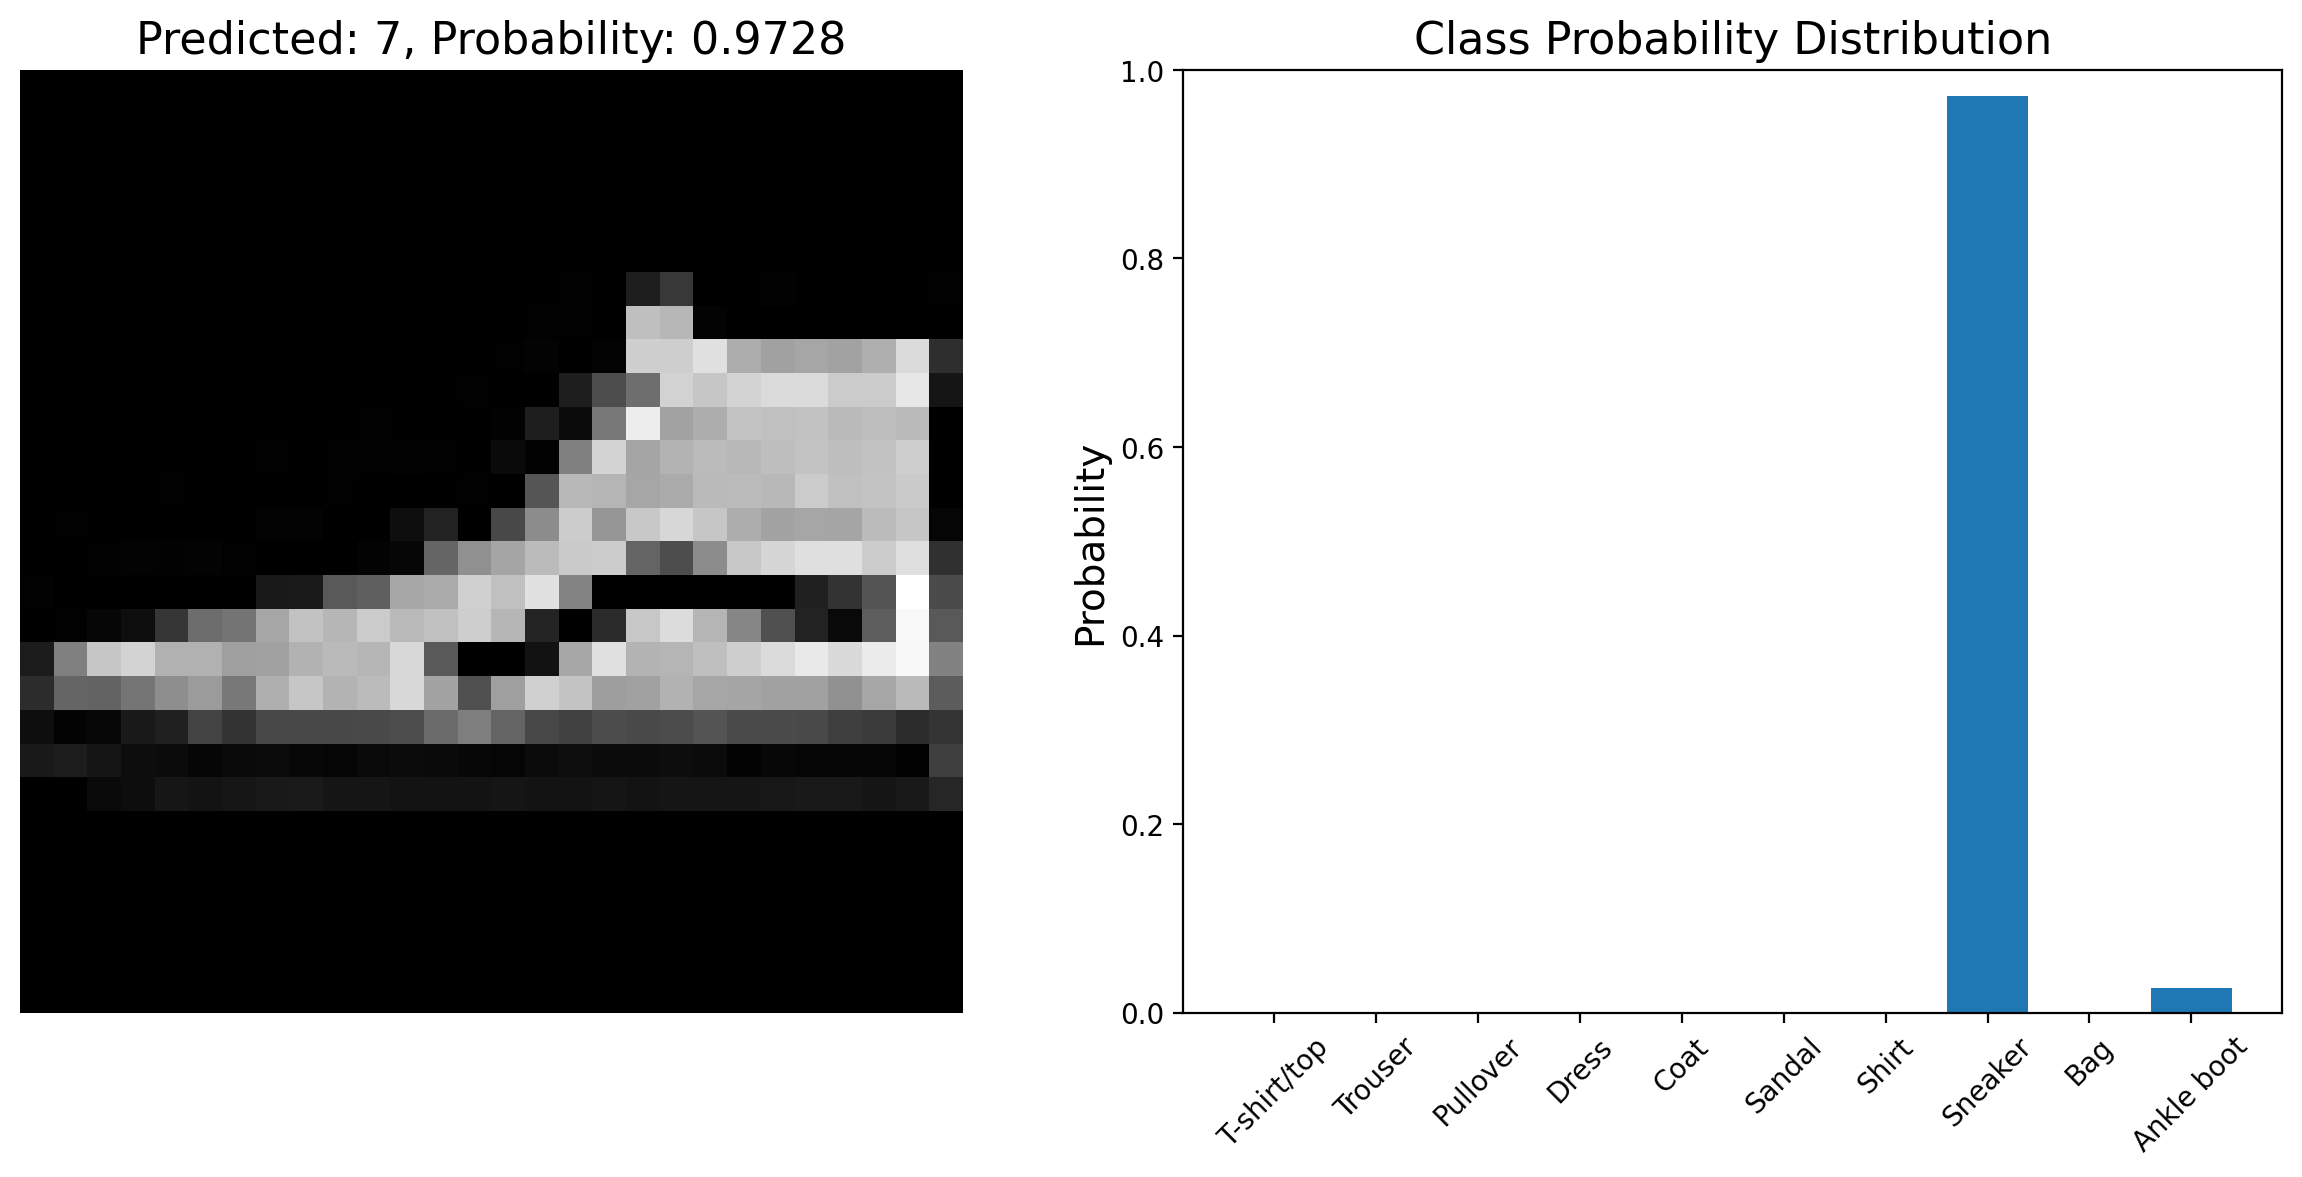

In [70]:
import matplotlib.pyplot as plt
import torch

# Inline plotting commands for Jupyter Notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Testing the network
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (log softmax) for img
ps = torch.exp(model(img))

# Define the view_classify function
def view_classify(img, ps, version='Fashion'):
    """Function for displaying an image and its predicted probability distribution"""

    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 1. Display the image in the first subplot
    img = img.view(28, 28).detach().numpy()  # 2D 이미지로 변환
    axes[0].imshow(img, cmap='gray')  # 이미지 시각화
    axes[0].set_title(f'Predicted: {ps.argmax().item()}, Probability: {ps.max().item():.4f}', fontsize=16)  # 타이틀 크기 조정
    axes[0].axis('off')  # 축 비활성화

    # 2. Display the probability distribution as a bar chart in the second subplot
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # 클래스 이름
    axes[1].bar(classes, ps.view(-1).detach().numpy())  # 확률 바 차트
    axes[1].set_title('Class Probability Distribution', fontsize=16)  # 타이틀 크기 조정
    axes[1].set_ylabel('Probability', fontsize=14)  # y축 레이블
    axes[1].set_xticklabels(classes, rotation=45)  # x축 레이블 회전
    axes[1].set_ylim(0, 1)  # y축 범위 설정

    # Show the plots
    plt.tight_layout()  # 레이아웃 조정
    plt.show()  # 그래프 표시

# Plot the image and probabilities using the view_classify function
view_classify(img, ps, version='Fashion')


**Saving the model**

In [71]:
print("My model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys())

My model: 

 Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])


#### 모델 설명

-   **Linear Layers (선형층)**:
    
    -   `(0): Linear(in_features=784, out_features=256)`는 입력 특성이 784개(28x28 이미지)이고, 출력 특성이 256개인 선형 변환을 의미합니다.
    -   같은 방식으로 다른 다양한 선형 변환이 후속 층들에 추가되어 있습니다.
    
-   **ReLU (비선형 활성화 함수)**:
    
    -   Relu층은 비선형성을 추가하여 모델이 다양한 패턴을 학습할 수 있도록 합니다.
    
-   **Dropout**:
    
    -   데이터 과적합을 방지하기 위해 사용되는 기법입니다. 서브 샘플로서 무작위로 입력 유닛을 제거하여 학습 과정에서 모델의 일반화를 돕습니다.
    
-   **LogSoftmax**:
    
    -   최종 출력층으로, 클래스 확률의 로그를 계산하여 다중 클래스 분류 문제에서 사용됩니다.
    

### 2\. 상태 사전 출력

print("The state dict keys: \n\n", model.state_dict().keys())


이 코드에서는 모델의 상태 사전(state dict)의 키를 출력합니다. 상태 사전은 모델의 모든 학습 가능한 파라미터(가중치 및 편향)를 담고 있습니다. 출력 내용은 다음과 같습니다:

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])


#### 상태 사전 설명

-   `0.weight`, `0.bias`: 첫 번째 선형층(784 -> 256)의 가중치와 편향을 나타냅니다.
-   `3.weight`, `3.bias`: 두 번째 선형층(256 -> 128)의 가중치와 편향을 나타냅니다.
-   `6.weight`, `6.bias`: 세 번째 선형층(128 -> 64)의 가중치와 편향을 나타냅니다.
-   `9.weight`, `9.bias`: 마지막 선형층(64 -> 10)의 가중치와 편향을 나타냅니다.

이 상태 사전은 모델의 학습이 완료된 후 모델을 저장하거나 로드하는 데 사용됩니다. 각 키는 특정 레이어의 가중치 및 편향을 식별할 수 있도록 되어 있습니다.

### 요약

-   모델 구조는 여러 층으로 구성되어 있으며, Linear, ReLU, Dropout, LogSoftmax 등 다양한 구성 요소로 이루어져 있습니다.
-   상태 사전은 각 레이어의 가중치와 편향을 저장하고 관리하는 방식입니다.

In [72]:
torch.save(model.state_dict(), 'checkpoint.pth')

**Load the saved model**

In [73]:
state_dict = torch.load("checkpoint.pth")
print(state_dict.keys())

odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])


주어진 코드는 PyTorch를 사용하여 저장된 모델의 상태 사전(state dict)을 로드하고, 그 키를 출력하는 부분입니다. 또한, 경고 메시지가 나타나는 부분도 포함되어 있습니다. 아래에서 각 부분을 자세히 설명하겠습니다.

### 1\. 모델 상태 사전 로드

state_dict = torch.load("checkpoint.pth")
print(state_dict.keys())

이 코드는 `checkpoint.pth` 파일에서 모델의 상태 사전을 로드합니다. `state_dict`는 모델의 가중치와 편향 같은 학습 가능한 매개변수를 포함합니다. 이 후에는 키를 출력하여 저장된 매개변수를 확인합니다.

#### 출력 예시:

출력 예시:
odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias'])

-   이 출력은 로드된 상태 사전에 포함된 각 매개변수의 이름(키)을 나열합니다.
-   예를 들어, `'0.weight'`와 `'0.bias'`는 첫 번째 선형 층에 대한 가중치와 편향을 의미합니다.

### 2\. 경고 메시지

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_34228\481109060.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling..

이 경고는 `torch.load()`를 사용할 때 `weights_only=False` 설정이 기본값이라는 내용입니다. 이 설정은 모델 저장 및 로드 시 보안 문제가 발생할 수 있음을 알립니다.

#### 경고 내용 설명:

-   **보안 관련**: 비신뢰 모델이나 외부 출처의 모델을 로드할 경우 악성 코드 실행 위험이 있습니다. 따라서, 사용자에게 신뢰할 수 없는 소스에서 모델을 로드할 때 주의를 기울이도록 하고 있습니다.
-   **weights\_only**: 향후 버전에서는 이 기본값이 `True`로 변경될 예정입니다. 이는 사용자가 고의적으로 혹은 실수로 신뢰할 수 없는 데이터 또는 객체를 로드하지 않도록 하기 위한 것입니다.
-   **권장 사항**: 만약 모델의 가중치만 로드할 경우, `torch.load("checkpoint.pth", weights_only=True)`와 같은 식으로 명시적으로 설정하는 것이 좋습니다.

### 요약

-   `torch.load("checkpoint.pth")`를 통해 모델의 상태 사전을 로드하고, 그 키를 출력하여 어떤 매개변수가 저장되어 있는지 확인합니다.
-   경고 메시지는 `torch.load()` 사용 시 보안 문제를 알려주며, 향후 업데이트에 대한 주의를 요구합니다. 안전한 모델 로드 관행을 따르는 것이 중요합니다.

In [74]:
# Load the state dict to the network
model.load_state_dict(state_dict)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
)
